## Toxicogenomics Time-Series Data Analytics

Ask Biology Professor: what toxic chemical with what concentration on what strain? Any prior on it?

Potentil links：https://zhuanlan.zhihu.com/p/67832773

Pipeline

1. feature clustering via spectral clustering to have top 3 variable -> feed into Bayesian SVAR model
2. Check network AR paper
    - Professor who did Network VAR ：https://xueningzhu.github.io/publications/
3. Derive its Bayesian formula
    - Prior
    - Likelihood



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Prepare and Clean the data 

In [3]:
# load gene library
lib = pd.read_excel("/Users/zijianleowang/Downloads/1000_genes_10_replicates_1_concentrations/Ecoli Lib/e.coli-promoter-library-0222.xls",
                    sheet_name="ALL")
lib = lib.loc[~lib["Gene_Name"].isna(),:][["Gene_Name","Description"]]
lib.columns = ["GeneName","Description"]

# remove duplicated GeneName
lib = lib.drop_duplicates("GeneName")
print(lib.head)

<bound method NDFrame.head of      GeneName                                        Description
0         aer           aerotaxis sensor receptor, flavoprotein 
1        amiC    N-acetylmuramoyl-L-alanine amidase (2nd module)
2        argA  N-alpha-acetylglutamate synthase (amino-acid a...
3        argC  N-acetyl-gamma-glutamylphosphate reductase, NA...
4        argD  acetylornithine transaminase (NAcOATase and Da...
...       ...                                                ...
1924     yafZ                               hypothetical protein
1925     ybjG                                  putative permease
1927     yfbM                                  conserved protein
1928     yoaD                     conserved protein (2nd module)
1930     yebQ                                        unknown CDS

[1809 rows x 2 columns]>


In [36]:
pathin = "/Users/zijianleowang/Downloads/1000_genes_10_replicates_1_concentrations"
tp_path = os.listdir(pathin) # timepoint path
tp_path = sorted([temp for temp in tp_path if (not temp.startswith(".") and temp.endswith(".tsv"))]) # sorted time points file from t0 to t24


for i,tp in enumerate(tp_path): # i shows time point
    dfi = pd.read_csv(os.path.join(pathin,tp),
                sep="\t") # 1760 genes x [GeneName, GeneID, 10 replicates]
    merged_dfi = pd.merge(dfi,lib,on="GeneName",how="inner").sort_values("GeneID") 
    merged_dfi = merged_dfi.reindex(sorted(merged_dfi.columns,reverse=True), axis=1)
    
    
    if i==0: # time point 0
        # save mean
        mean_df = pd.concat([merged_dfi.iloc[:,:3],
                          merged_dfi.iloc[:,3:].mean(axis=1)],axis=1)
        mean_df.columns = mean_df.columns[:-1].tolist() + ["t%i"%i]
        
        # save each replicate
        replicates = [] # init replicates list
        for j in range(merged_dfi.shape[1]-3): # j denotes replicate
            merged_dfij = merged_dfi[["GeneName","GeneID","Description",str(j)]]
            merged_dfij.columns = ["GeneName","GeneID","Description","t%i"%i]
            replicates.append(
                merged_dfij
            )
    else: 
        # save mean
        mean_dfi = pd.concat([merged_dfi.iloc[:,:3],
                          merged_dfi.iloc[:,3:].mean(axis=1)],axis=1)
        mean_dfi.columns = mean_dfi.columns[:-1].tolist() + ["t%i"%i] 
        mean_df = pd.merge(mean_df,mean_dfi,on=["GeneName","GeneID","Description"],how="inner")

        # save each replicate
        for j in range(merged_dfi.shape[1]-3):
            merged_dfij = merged_dfi[["GeneName","GeneID","Description",str(j)]]
            merged_dfij.columns = ["GeneName","GeneID","Description","t%i"%i]
            replicates[j] = pd.merge(replicates[j], merged_dfij, on=["GeneName","GeneID","Description"],how="inner")

# save mean
mean_df.to_csv(os.path.join(pathin,"replicates","mean.csv"),index=False)
# save replicates
for j,dfj in enumerate(replicates):
    dfj.to_csv(os.path.join(pathin,"replicates","replicates%i.csv"%j),index=False)


# viz the data

Text(0.5, 0, 'Time points')

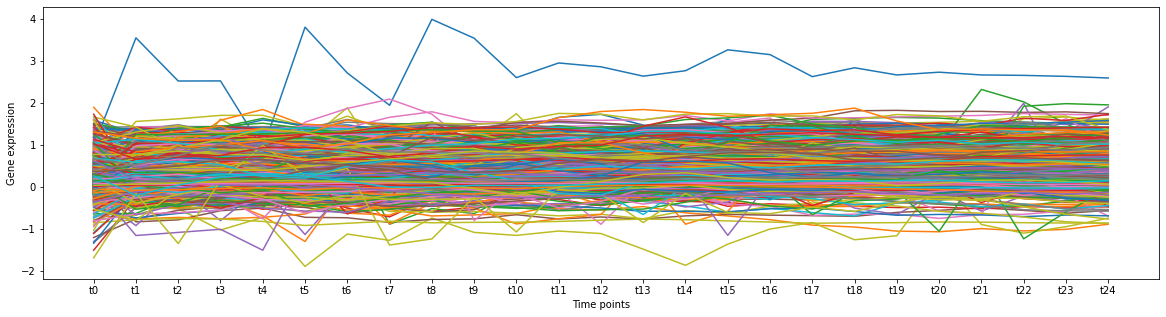

In [2]:
meangenes = pd.read_csv("/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/data/replicates/mean.csv")
genename = meangenes.iloc[:,0]
plt.figure(figsize=(20,5))
for i in range(1760):
    genei = meangenes.iloc[i,3:]
    plt.plot(genei,label=genename[i])
plt.ylabel("Gene expression")
plt.xlabel("Time points")
# plt.legend()

In [4]:
genes = meangenes.iloc[:,3:].T # n x d
# normalize L2 on columns
from sklearn.preprocessing import normalize
genes = normalize(genes,norm='l2',axis=0)
genes = pd.DataFrame(genes)
genes.columns = genename
genes.index = meangenes.columns[3:]
print(genes.shape)
genes.head()

(25, 1760)


GeneName,kdtA,pheP,yhiP,stfR,ybjJ,ycbW,ycaI,yfjL,htpX,ydcI,...,mreC,ynfB,aroK,yhiD,ydcA,yrbF,pgi,aroP,yafU,yhdN
t0,0.243187,0.244305,0.022183,0.536984,0.327218,0.166823,0.275387,0.021600,0.657020,0.347357,...,0.041890,-0.518321,0.188902,0.043605,0.613876,0.121484,0.215067,-0.055699,0.052235,0.348528
t1,0.196767,0.015472,-0.036894,0.273985,0.257711,0.103024,0.267561,0.037761,0.050114,0.188185,...,0.040447,0.025819,0.165866,0.113708,0.172265,0.137409,0.153031,0.129532,0.091434,-0.257742
t2,0.209116,0.036088,-0.030906,0.200332,0.331476,0.097701,0.186203,0.052783,0.089141,0.185358,...,0.063734,0.210871,0.155956,0.145894,0.127542,0.163498,0.155990,0.195295,0.120734,0.058667
t3,0.204748,0.019969,-0.039598,0.150517,0.316932,0.053843,0.087662,0.043288,0.129288,0.176347,...,0.072012,0.215618,0.233438,0.207572,0.051921,0.211137,0.202053,0.133348,0.167999,0.310374
t4,0.163329,0.020529,-0.041583,0.175941,0.330421,0.071861,0.061048,0.027443,0.124347,0.175580,...,0.075730,0.233118,0.236623,0.242339,0.048066,0.211573,0.191493,0.150499,0.203039,0.413042


## try clustering algorithm
### Spectral Clustering

(1760, 25)


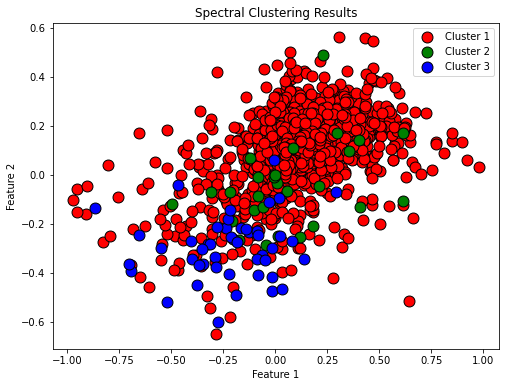

In [189]:
X = genes.to_numpy().T
print(X.shape)

# Apply SpectralClustering
n_clusters = 3  # Specify the number of clusters you want to obtain
sc = SpectralClustering(n_clusters=n_clusters, 
                        gamma=2,
                        affinity='poly', 
                        random_state=170)
labels = sc.fit_predict(X)

# Plotting the clusters with different colors
colors = ['red', 'green', 'blue', 'orange', 'purple']  # Customize the colors as per your preference

plt.figure(figsize=(8, 6))

# Iterate over each cluster and plot the points with corresponding color
for i in range(n_clusters):
    cluster_points = X[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=colors[i], label=f'Cluster {i+1}',
               s=120,edgecolor='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spectral Clustering Results')
plt.legend()
plt.show()


## The spectral clustering algorithms fails to separate them clearly, so I am trying DBSCAN now.

Estimated number of clusters: 3
Estimated number of noise points: 68


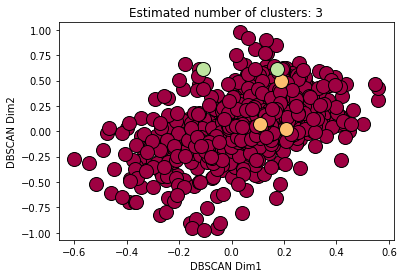

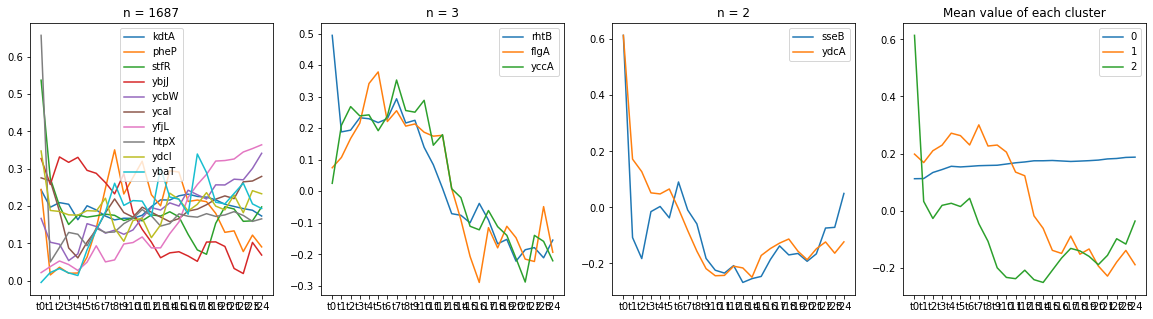

In [8]:
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn import metrics

db = DBSCAN(eps=0.58, min_samples=2).fit(genes.T)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print(f"Silhouette Coefficient: {metrics.silhouette_score(genes, labels):.3f}")

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = genes.T[class_member_mask & core_samples_mask].T # plot the core samples identified, Time x Genes
    if min(xy.shape)>=2:
        plt.plot(
            xy.iloc[1,:],
            xy.iloc[0,:],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )
plt.xlabel("DBSCAN Dim1")
plt.ylabel("DBSCAN Dim2")
plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

fig, ax = plt.subplots(1,n_clusters_+1,figsize=(20,5))
# plot each clusteri
for labeli in set(labels):
    if labeli >= 0:
        clusteri = genes.T[(labels==labeli) & core_samples_mask].T
        # plot single
        for i in range(min(10,clusteri.shape[1])): # plot at most 10 genes 
            ax[labeli].plot(clusteri.iloc[:,i],label=clusteri.columns[i])
        ax[labeli].set_title("n = %i"%sum((labels==labeli) & core_samples_mask))
        ax[labeli].legend()

# create cluster matrix and plot average
cluster_matrix = np.zeros((genes.shape[1], n_clusters_), dtype=int)
clustered_genes = pd.DataFrame()

for i in range(n_clusters_):
    # save cluster matrix
    cluster_matrix[labels == i, i] = 1
    # save mean
    clusteri = genes.T[(labels==i) & core_samples_mask].T # T x clustered genes
    meani = clusteri.mean(axis=1)
    stdi = clusteri.std(axis=1)
    # save mean values for each cluster
    clustered_genes = pd.concat([clustered_genes,meani],axis=1)
    
    # plot
    ax[-1].plot(meani,label=i)
    ax[-1].set_title("Mean value of each cluster")
ax[-1].legend()


## The clustered genes can be retrieved back to gene library to understand some priors for later sign restriction assumptions

- cluster0 

- cluster1 consists of genes rhtB, flgA, yccA
    - rhtB	RhtB homoserine Rht Transporter
    - flgA	flagellar biosynthesis; assembly of basal-body periplasmic P ring
    - yccA	putative TEGT family transport protein
    
- cluster2 consists of genes sseB, ydcA
    - sseB	enhances serine sensitivity
    - ydcA	unknown CDS

## Analysis based on Gene Set Enrichment [GESApy](https://github.com/zqfang/GSEApy)

In [380]:
df_gseapy = genes.T.reset_index()
df_gseapy["GeneName"] = df_gseapy["GeneName"].str.upper()
df_gseapy.to_csv("/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/data/gseapy.toxic.csv")
df_gseapy.head()

,GeneName,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24
0,KDTA,0.243187,0.196767,0.209116,0.204748,0.163329,0.200669,0.189592,0.173098,0.162793,...,0.227354,0.231817,0.225707,0.223795,0.216604,0.204752,0.198840,0.193091,0.188706,0.173141
1,PHEP,0.244305,0.015472,0.036088,0.019969,0.020529,0.063103,0.140596,0.247574,0.350417,...,0.290950,0.212114,0.216043,0.211591,0.180319,0.129538,0.133486,0.078011,0.122095,0.090561
2,YHIP,0.022183,-0.036894,-0.030906,-0.039598,-0.041583,0.117736,0.321791,0.331913,0.219588,...,0.359610,0.343844,0.231099,0.218727,0.206241,0.204915,0.084579,-0.009452,0.013575,-0.012885
3,STFR,0.536984,0.273985,0.200332,0.150517,0.175941,0.170215,0.173871,0.178251,0.175038,...,0.171088,0.123929,0.082555,0.070781,0.153712,0.197942,0.192042,0.159028,0.160345,0.197518
4,YBJJ,0.327218,0.257711,0.331476,0.316932,0.330421,0.295578,0.287579,0.262676,0.232518,...,0.077565,0.066157,0.051886,0.103498,0.103967,0.091740,0.032759,0.019219,0.102525,0.068719


## GSEA with each time point as a single sample
Gene Set Enrichment Analysis (GSEA) is a computational method used to determine whether a pre-defined set of genes shows statistically significant differences in expression between *two biological states or conditions*. It helps to identify gene sets that are associated with specific biological processes, pathways, or functions.

   Name                                      Term        ES       NES  \
0  gsea  Metabolic pathways Homo sapiens hsa01100  0.346218  1.019691   

  NOM p-val FDR q-val FWER p-val Tag %  Gene %  \
0  0.450617  0.450617      0.219  9/19  26.59%   

                                  Lead_genes  
0  ASNS;PNP;LDHA;SDHC;CHIA;ADK;GALE;DGKA;GPT  


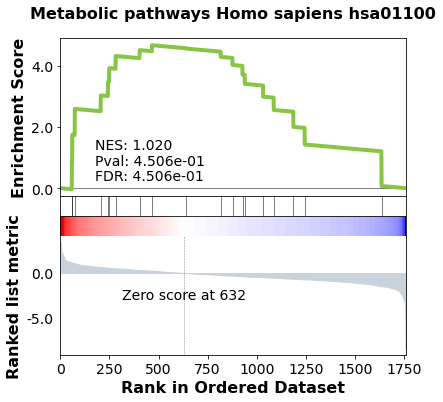

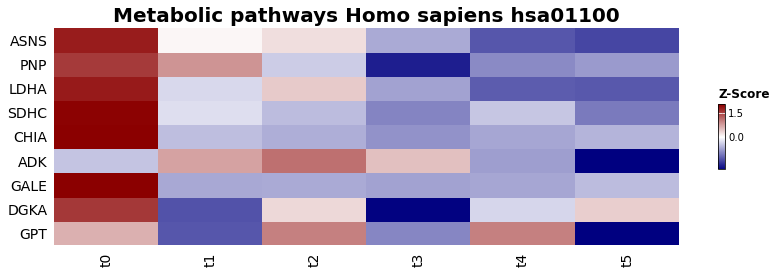

In [441]:
gs_res = gseapy.gsea(data=df_gseapy.iloc[:,:7], # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # or enrichr library names
                 cls= ["A"]*3 + ["B"]*3, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7)

print(gs_res.res2d.head())

terms = gs_res.res2d.Term
i = 0
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseapy.gseaplot(gs_res.ranking, term=terms[i], **gs_res.results[terms[i]])

# plotting heatmap
genes_ht = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = gseapy.heatmap(df = gs_res.heatmat.loc[genes_ht], z_score=0, title=terms[i], figsize=(14,4))

# https://gseapy.readthedocs.io/en/latest/gseapy_example.html#Single-Sample-GSEA-example
# from gseapy import ringplot
# ax = gseapy.dotplot(gs_res.res2d,
#              column="FDR q-val",
#              title='KEGG_2021_Human',
#              cmap=plt.cm.viridis,
#              size=5,
#              figsize=(4,5), cutoff=1)

## single sample GSEA

In [439]:
import gseapy
import imp
imp.reload(gseapy)

# trial for enrichr shows it is not what i need
# genelist = pd.read_csv("/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/data/Ecoli Lib/ecoligenelist.txt",
#                       header=None)[0].tolist()
# gseapy.enrichr(gene_list=genelist,gene_sets="KEGG_2016",
#                cutoff=1,
#                outdir="/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/data/Ecoli Lib/genelistenrichr")

# problem of database?
ss = gseapy.ssgsea(data=df_gseapy, gene_sets='KEGG_2016', 
              sample_norm_method = "log_rank",
              verbose=True,
              outdir='/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/output/')

ss.res2d

,Name,Term,ES,NES
0,t5,Metabolic pathways Homo sapiens hsa01100,-451.432163,-0.818435
1,t6,Metabolic pathways Homo sapiens hsa01100,-402.439893,-0.729613
2,t4,Metabolic pathways Homo sapiens hsa01100,-399.332911,-0.72398
3,t3,Metabolic pathways Homo sapiens hsa01100,-332.332546,-0.60251
4,t12,Metabolic pathways Homo sapiens hsa01100,-226.414814,-0.410484
5,t1,Metabolic pathways Homo sapiens hsa01100,-213.856587,-0.387717
6,t9,Metabolic pathways Homo sapiens hsa01100,-207.818689,-0.37677
7,t7,Metabolic pathways Homo sapiens hsa01100,-205.106099,-0.371852
8,t2,Metabolic pathways Homo sapiens hsa01100,-171.593838,-0.311095
9,t8,Metabolic pathways Homo sapiens hsa01100,-109.687786,-0.198861


## Select directly arsenic toxicogenomics relevant genes in E. coli based on prior knowledge
1. rpoS	sigma S (sigma 38) factor of RNA polymerase, major sigmafactor during stationary phase. The rpoS gene encodes the sigma factor σs, which regulates the expression of genes involved in the general stress response. It has been shown to be important in E. coli's response to arsenic stress.

2. b2639	CP4-57 prophage; putative arsenical pump protein. 

3. recA	 DNA repair relevant. DNA strand exchange and recombination protein with proteiase and nuclease activity (1st module)

4. glutathione-related genes: Genes involved in glutathione biosynthesis and metabolism play a crucial role in arsenic detoxification. Glutathione (GSH) acts as a chelator for arsenic and contributes to its sequestration and elimination from the cell. Genes such as gshA, gshB, and gshC are involved in glutathione synthesis.
    - yfcG	putative glutathione S-transferase
    - yncG	putative glutathione S-transferase
    - grxA	glutaredoxin1 redox coenzyme for glutathione-dependent ribonucleotide reductase
    
But this dataset only has some above genes, so I picked b2639, yfcG, grxA for downstream analysis

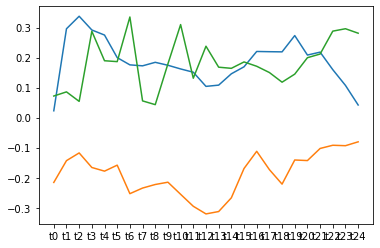

In [58]:
prior_genes = genes[["b2639","yfcG","grxA"]]
plt.plot(prior_genes)

In [207]:
## PCA test
# from sklearn.decomposition import PCA, KernelPCA

# pca = PCA(n_components=2)
# kernel_pca = KernelPCA(
#     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
# )
# genes_pca = pca.fit_transform(genes.T)
# genes_Kpca = kernel_pca.fit_transform(genes.T)

# fig, ax = plt.subplots(1,2,figsize=(20,5))
# ax[0].scatter(genes_pca[:,0],genes_pca[:,1],c)

## check the prior info for toxicogenomics of E. coli
- every 5 min
- under asernic shock


## check the network VR model and how to transform it into Bayesian NVR

### get the non-dynamic weighted adjacency matrix, nodal matrix based on clustering results

In [30]:
# import imp

# # imp.reload(pypanda)
# from pypanda import Panda
# from pypanda import Lioness
# import pandas as pd
# from pypanda.analyze_panda import AnalyzePanda
# from pypanda.analyze_lioness import AnalyzeLioness

# p = Panda("/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/output/ToyExpressionData.txt"
#           ,"/Users/zijianleowang/Downloads/Cornell/1Ongoing.Project/1000_genes_10_replicates_1_concentrations/output/ToyMotifData.txt")

In [29]:
# # failed trial using pgmpy
# import pandas as pd
# import networkx as nx
# from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
# from pgmpy.inference import VariableElimination
# from pgmpy.models import BayesianNetwork

# # Load your dataframe into a pandas DataFrame


# # Create an empty BayesianModel
# model = BayesianNetwork()

# # # Add nodes to the model
# model.add_nodes_from(genes.columns)
# # Estimate the model parameters
# model.fit(genes, estimator=BayesianEstimator)
# inference = VariableElimination(model)
# # Get the adjacency matrix
# adjacency_matrix = model.adjacency()


# # Print the adjacency matrix
# print("Adjacency Matrix:")
# print(adjacency_matrix)
# inference.query(["kdtA"])

### Compute weighted adjacency matrix between nodes by considering {t0, t1, ..., t_i} for i=1, 2, ..., 24

In [44]:
prmt = np.corrcoef(genes.T) # pearson matrix for gene expression
N, N = prmt.shape # N genes
threshold = 0.8
adjacency_mt = np.zeros((N,N)) # get the adjacency matrix

# Iterate over the Pearson correlation matrix
for i in range(N):
    for j in range(i + 1, N): # i+1 instead of i to avoid self-loop
        if prmt[i, j] > threshold: 
            adjacency_mt[i,j] = 1
            adjacency_mt[j,i] = 1 # symmetry
            
print("%i has edges"%sum(sum(adjacency_mt==1)))
# normalize it 
row_sum = np.sum(adjacency_mt, axis=1)
nonzero_indices = np.nonzero(row_sum)

# Normalize the matrix based on its row sum, only for non-zero row sums
normalized_matrix = np.zeros_like(adjacency_mt)
normalized_matrix[nonzero_indices] = adjacency_mt[nonzero_indices] / row_sum[nonzero_indices, np.newaxis]

64748 has edges


### viz the adjacency matrix

### Assign nodal feature matrix using cluster_matrix 

In [53]:
cluster_matrix # i-th column is cluster i; each entry is 1 if it belongs to cluster i, 0 otherwise

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

### These are sparse matrix

In [56]:
import scipy
normalized_matrix = scipy.sparse.csr_matrix(normalized_matrix)
cluster_matrix = scipy.sparse.csr_matrix(cluster_matrix)

## save data into .mat data format for MATLAB code

In [59]:
import scipy.io as sio

# data dictionary
OutData = {} 

# convert DF to dictionary before loading to your dictionary
OutData['tox'] = genes.T.values # the Time x Genes dataframe
OutData['GeneName'] = genes.columns.values # all gene name
OutData['tox_cluster'] = clustered_genes.T.values # 3 genes selected by DBSCAN clustering algo
OutData['tox_prior'] = prior_genes.T.values # 3 genes selected by prior knowledge
OutData['normed_adjacency'] = normalized_matrix
OutData['nodal_feature'] = cluster_matrix

sio.savemat('/Users/zijianleowang/Desktop/Projects_in_Cornell/Course/23Spring/Bayesian/code/lecture_6_svar_lr_sr/SR_VAR_MH/toxicogenomics.mat',
            OutData,
            appendmat=False)

## What else to try?
- Bayesian networks
- Gene set enrichment analysis for bacteria
- Assign sign restriction based on prior knowledge about arsenic 
- Dynamic gene regulatory network estimation
- Bayesian dynamical NVAR?